## RESNET-18 transformed to SNN and tested with cifar-10

In [1]:
import tensorflow as tf
from ml_genn import Model
from ml_genn.converters import RateBased, FewSpike
from ml_genn.utils import raster_plot
import numpy as np
from six import iteritems
from time import perf_counter
import argparse
from ml_genn.converters import rate_based
from ml_genn.layers import ConnectivityType
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)

## Downloading and preprocessing dataset

In [20]:
data = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = data.load_data()

c:\users\jfgf1\anaconda3\envs\genn_env_tf\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


Image Classes:[6, 9, 9, 4, 1]
Image Labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


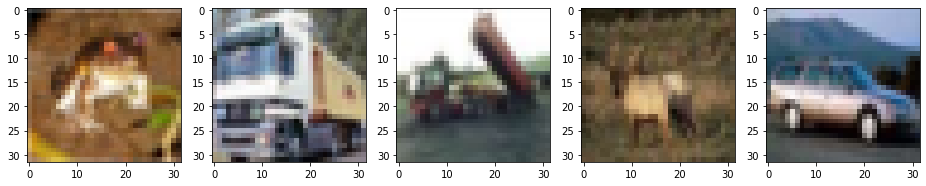

In [21]:
%matplotlib inline
fig, ax = plt.subplots(1, 5)
fig.set_size_inches(16, 6)
for i in range(0,5):
    img = train_images[i]
    ax[i].imshow(img)
    fig.show()
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Image Classes:' + str([x[0] for x in train_labels[0:5]]))
print('Image Labels: ' + str([classes[x[0]] for x in train_labels[0:5]]))


train_images = train_images / 255.0
test_images =  test_images / 255.0

# apparently the OneHotEncoder improves the measurements in this case.... it did...
encoder = OneHotEncoder()
encoder.fit(train_labels)
train_labels = encoder.transform(train_labels).toarray()
test_labels = encoder.transform(test_labels).toarray()


In [5]:
x_norm = train_images[np.random.choice(train_images.shape[0], 256, replace=False)]

### Data augmentation

In [6]:
data_gen = tf.keras.preprocessing.image.ImageDataGenerator(horizontal_flip=True,
                                                           width_shift_range=0.05,
                                                           height_shift_range=0.05)
data_gen.fit(train_images)

## Creating ResNet model

In [7]:
class ResnetFunctionalIdentity(tf.keras.Model):
    def __init__(self, filters, identity_cnn=False):
        super(ResnetFunctionalIdentity, self).__init__()
        
        self.strides = [2, 1] if identity_cnn else [1, 1]
        self.identity_cnn = identity_cnn
        KERNEL_SIZE = (3,3)
        W_INIT = 'he_normal'
        
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=KERNEL_SIZE, padding='same', strides=self.strides[0], kernel_initializer=W_INIT)
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=KERNEL_SIZE, padding='same', strides=self.strides[1], kernel_initializer=W_INIT)
        
        #self.bn1 = tf.keras.layers.BatchNormalization()
        #self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.convI = tf.keras.layers.Conv2D(filters, kernel_size=(1,1), padding='same', strides=2, kernel_initializer=W_INIT)
        
        self.act = tf.keras.layers.Activation('relu')
        self.add = tf.keras.layers.Add()
        
        
    def call(self, input_tensor):
        x = self.conv1(input_tensor)
        #batch but I don't know if I can add it (ask)
        #x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        #x = self.bn2(x)
    
        res = self.convI(input_tensor) if self.identity_cnn else input_tensor
        
        # you must add batch to res if you can
        
        x = self.add([x, res])
        x = self.act(x)
        
        return x

In [8]:
class ResNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(ResNet, self).__init__()
        self.conv = tf.keras.layers.Conv2D(64, (7,7), padding='same', kernel_initializer='he_normal')
        self.act = tf.keras.layers.Activation('relu')
        self.max_pool = tf.keras.layers.MaxPool2D((3,3))
        self.res_1 = ResnetFunctionalIdentity(64, 3)
        self.res_2 = ResnetFunctionalIdentity(64, 3)
        self.res_list = []
        counter = -1
        for i in range(1,7):
            counter += 1 if i%2==1 else 0
            self.res_list.append(ResnetFunctionalIdentity(128*(2**counter), i%2))
        
        self.global_pool = tf.keras.layers.GlobalAveragePooling2D()
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')
    
    def call(self, inputs):
        x = self.conv(inputs)
        #batch
        x = self.act(x)
        x = self.max_pool(x)
        
        x = self.res_1(x)
        x = self.res_2(x)
        
        for res in self.res_list:
            x = res(x)
        x = self.global_pool(x)
        
        return self.classifier(x)

Creating ResNet instance with 10 output units for the CIFAR-10 dataset

In [38]:
resnet = ResNet(10)
resnet.build(input_shape = (None,32,32,3))
resnet.summary()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "res_net_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          multiple                  9472      
_________________________________________________________________
activation_54 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_functional_identity_4 multiple                  78016     
_________________________________________________________________
resnet_functional_identity_4 multiple                  78016     
_________________________________________________________________
resnet_functional_identity_5 multiple                  229760    
_________________________________________________________________
resnet_functional_identity_5 multiple                  29

## Training Model

In [39]:
steps_per_epoch = train_labels.shape[0] // 256
#
# checkpoint_filepath = '/tmp/checkpoint'
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_filepath,
#     save_weights_only=False,
#     monitor='val_accuracy',
#     mode='max',
#     save_best_only=True)


history = resnet.fit(data_gen.flow(train_images, train_labels, batch_size=256),
           validation_data=(test_images, test_labels), 
           epochs=50,
           steps_per_epoch=steps_per_epoch,
           batch_size=256)

Epoch 1/50
195/195 [==============================] - 20s 99ms/step - loss: 1.9548 - accuracy: 0.2913 - val_loss: 1.4145 - val_accuracy: 0.4825
Epoch 2/50
195/195 [==============================] - 19s 98ms/step - loss: 1.4157 - accuracy: 0.4901 - val_loss: 1.3459 - val_accuracy: 0.5194
Epoch 3/50
195/195 [==============================] - 19s 99ms/step - loss: 1.2703 - accuracy: 0.5472 - val_loss: 1.2153 - val_accuracy: 0.5674
Epoch 4/50
195/195 [==============================] - 20s 103ms/step - loss: 1.1639 - accuracy: 0.5772 - val_loss: 1.1459 - val_accuracy: 0.5922
Epoch 5/50
195/195 [==============================] - 21s 110ms/step - loss: 1.0885 - accuracy: 0.6123 - val_loss: 1.1177 - val_accuracy: 0.6062
Epoch 6/50
195/195 [==============================] - 24s 123ms/step - loss: 1.0376 - accuracy: 0.6304 - val_loss: 1.0400 - val_accuracy: 0.6325
Epoch 7/50
195/195 [==============================] - 22s 113ms/step - loss: 0.9582 - accuracy: 0.6618 - val_loss: 1.0418 - val_accur

KeyboardInterrupt: 

In [40]:
resnet.save('resnet_tf_model', save_format='tf')

INFO:tensorflow:Assets written to: resnet_tf_model\assets


In [13]:
tf_eval_start_time = perf_counter()
resnet.evaluate(test_images, test_labels)
print("TF evaluation:%f" % (perf_counter() - tf_eval_start_time))

313/313 [==============================] - 27s 54ms/step - loss: 0.8701 - accuracy: 0.7041
TF evaluation:26.764478


In [12]:
resnet = tf.keras.models.load_model('resnet_tf_model')
resnet.summary()

resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "res_net_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_150 (Conv2D)          multiple                  9472      
_________________________________________________________________
activation_54 (Activation)   multiple                  0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
resnet_functional_identity_4 multiple                  78016     
_________________________________________________________________
resnet_functional_identity_4 multiple                  78016     
_________________________________________________________________
resnet_functional_identity_5 multiple                  229760    
_________________________________________________________________
resnet_functional_identity_5 multiple                  29

In [49]:
converter = FewSpike(K=10, signed_input=True, norm_data=[x_norm])




# RateBased(input_type='poisson', 
#                                 norm_data=[x_norm],
#                                 norm_method='data-norm',
#                                 spike_norm_time=2500)

In [50]:
# Convert and compile ML GeNN model
mlg_model = Model.convert_tf_model(
    resnet, converter=converter, connectivity_type='procedural',
    dt=1.0, batch_size=1, rng_seed=0, 
    kernel_profiling='store_true')

NotImplementedError: <class '__main__.ResNet'> models not supported